In [1]:
from endv_all_sites import create_data_dict
from make_fpar_stats import fpar_stats
from process_flux_data import process_flux_data
from pull_nc_NEE import pull_rs_NEE
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from itertools import cycle, islice

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [2]:
site_coords = {'vaira': [38.4133, -120.9508],
               'tonzi': [38.4309, -120.9660],
               'ME4': [44.4992, -121.6224],
               'ME5': [44.4372, -121.5668]}

data=np.load('fapar_vals_dict_365.npy', allow_pickle=True)
data = data[()]

site_wise_data = {}
for site in site_coords:
    site_wise_data[site] = {}
    for key in data:
        if site in str(key):
            site_wise_data[site][key] = np.mean(data[key])

vaira_df = pd.DataFrame({'keys' : site_wise_data['vaira'].keys() , 'fPAR' : site_wise_data['vaira'].values()})
tonzi_df = pd.DataFrame({'keys' : site_wise_data['tonzi'].keys() , 'fPAR' : site_wise_data['tonzi'].values()})
ME4_df = pd.DataFrame({'keys' : site_wise_data['ME4'].keys() , 'fPAR' : site_wise_data['ME4'].values()})
ME5_df = pd.DataFrame({'keys' : site_wise_data['ME5'].keys() , 'fPAR' : site_wise_data['ME5'].values()})
site_dfs = [vaira_df, tonzi_df, ME4_df, ME5_df]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [3]:
pull_rs_NEE()
monthly_NEE = np.load('NEE_vals_dict.npy', allow_pickle=True)
monthly_NEE = monthly_NEE[()]
vaira_NEE = pd.DataFrame(monthly_NEE['vaira']).iloc[0:12]
tonzi_NEE = pd.DataFrame(monthly_NEE['tonzi']).iloc[0:12]
ME4_NEE = pd.DataFrame(monthly_NEE['ME4']).iloc[0:12]
ME5_NEE = pd.DataFrame(monthly_NEE['ME5']).iloc[0:12]

all_NEE = [vaira_NEE, tonzi_NEE, ME4_NEE, ME5_NEE]

In [4]:
vavgf, vmaxf, vminf, vmonthly = fpar_stats(vaira_df)
tavgf, tmaxf, tminf, tmonthly = fpar_stats(tonzi_df)
avgf4, maxf4, minf4, monthly4 = fpar_stats(ME4_df)
avgf5, maxf5, minf5, monthly5 = fpar_stats(ME5_df)

/Users/Violet/Desktop/ccm_final/make_fpar_stats.py:54: RuntimeWarning: Mean of empty slice
  monthly_fpar.append(np.nanmean(i))
/Users/Violet/Desktop/ccm_final/make_fpar_stats.py:57: RuntimeWarning: Mean of empty slice
  yearly_fpar = np.nanmean(avg_monthly_fpar)


In [5]:
dfs, insitu = process_flux_data()

In [6]:
vairaX = insitu[0][['TA_F_MDS', 'P_ERA']]
vairaX['fpar'] = vmonthly
vairaX['max_fpar'] = vmaxf
vairaX['min_fpar'] = vminf
vairaX['fpar_yr_avg'] = vavgf
vairaX['IGBP V'] = 1
vairaX['IGBP T'] = 0
vairaX['IGBP E'] = 0

tonziX = insitu[1][['TA_F_MDS', 'P_ERA']]
tonziX['fpar'] = tmonthly
tonziX['max_fpar'] = tmaxf
tonziX['min_fpar'] = tminf
tonziX['fpar_yr_avg'] = tavgf
tonziX['IGBP V'] = 0
tonziX['IGBP T'] = 1
tonziX['IGBP E'] = 0

Xme4 = insitu[2][['TA_F_MDS', 'P_ERA']]
Xme4['fpar'] = monthly4
Xme4['max_fpar'] = maxf4
Xme4['min_fpar'] = minf4
Xme4['fpar_yr_avg'] = avgf4
Xme4['IGBP V'] = 0
Xme4['IGBP T'] = 0
Xme4['IGBP E'] = 1

In [7]:
#MTE predicted (y axis) versus FLUXNET observed (y axis) GPP, TER, NEE, LE, and H

In [8]:
#Y-axis (fluxnet observed)
fluxnet_NEE = dfs[0].append(dfs[1]).append(dfs[2])[['TIMESTAMP','NEE_CUT_USTAR50']]

In [9]:
#X-axis (model predicted)

#First, create X training data for the model from explanatory vars:
training_x = vairaX.append(tonziX).append(Xme4)
training_x.reset_index()
ms = list(np.arange(12)+1)
training_x['index'] = list(islice(cycle(ms), len(training_x)))

##create a feature indicating presence of rain
rain = [] 
for i in training_x['P_ERA']:
    if i > 0:
        rain.append(1)
    elif i <= 0:
        rain.append(0)
training_x['rain'] = rain

##create a feature indicating max-min fpar
training_x['fpar dif'] = training_x['max_fpar'] - training_x['min_fpar']

#Then, collect Y training data from remote sensing predicted NEE values
NEE_list = all_NEE[0].append(all_NEE[1]).append(all_NEE[2])
NEE_indexed = NEE_list.reset_index()
NEE_indexed['month'] = NEE_indexed['index'] + 1
rs_NEE = NEE_indexed.drop(labels = 'index', axis = 1)

In [10]:
# Evaulate hyperparameters & cross-validate with 3 folds
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
rfr = RandomForestRegressor()

In [11]:
#Produce NEE estimates from the model
X_train, X_test, y_train, y_test = tts(training_x, rs_NEE[0], test_size = .5)
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
pred = rf_random.predict(X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [12]:
print(rf_random.score(X_test, y_test))
print(rf_random.score(X_train, y_train))
print(rs_NEE[0].corr(fluxnet_NEE['NEE_CUT_USTAR50']))

0.004517262420188239
0.17304426226812708
0.3265968162718299


In [13]:
pred, fluxnet_NEE['NEE_CUT_USTAR50']

(array([-0.01618789, -0.01180111, -0.00975692, -0.01602787, -0.01061302,
        -0.00636983, -0.01080967, -0.01001001, -0.01241058, -0.01614582,
        -0.00834061, -0.01012533, -0.01160447, -0.00537759, -0.00972949,
        -0.01479769, -0.01136942, -0.00190854]),
 24   -0.092968
 25   -0.257451
 26   -1.767250
 27   -3.163730
 28    0.373906
 29    0.455460
 30    0.444843
 31    0.526267
 32    0.393457
 33    0.158393
 34    2.170380
 35    0.584225
 12   -0.225001
 13    0.538909
 14   -0.142010
 15   -1.943780
 16   -2.349780
 17   -1.769770
 18   -1.102430
 19   -0.523219
 20   -0.021390
 21   -0.268096
 22    1.250730
 23    0.942812
 24    0.124957
 25    0.080332
 26   -0.334093
 27   -1.034030
 28   -1.067090
 29   -1.422040
 30   -0.848304
 31   -0.646749
 32   -0.259251
 33   -0.239523
 34    0.064252
 35    0.604490
 Name: NEE_CUT_USTAR50, dtype: float64)

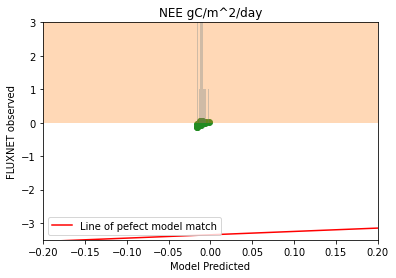

In [15]:
plt.scatter(pred, y_test, color = 'forestgreen') 
plt.hist(pred, alpha = 0.3)
plt.hist(fluxnet_NEE['NEE_CUT_USTAR50'], alpha = 0.3)
# y = x trendline
x = np.linspace(-2, 2, 500)
y = x - 3.35
plt.plot(x, y, color='red', label = 'Line of pefect model match')
plt.xlim(-0.2,0.2)
plt.ylim(-3.5,3);

plt.title('NEE gC/m^2/day')
plt.ylabel('FLUXNET observed')
plt.xlabel('Model Predicted')
plt.legend();

In [16]:
month0 = np.full(shape = 12, fill_value = 0)
month1 = np.full(shape = 12, fill_value = 1)
m11 = np.append(month1, month1)
m01 = np.append(month0, month0)
m001 = np.append(m01, month1)
m110 = np.append(m11, month0)
m011 = np.append(month0, m11)

yr12 = np.full(shape = 12, fill_value = 12)
yr1 = np.full(shape = 12, fill_value = 1)
yr3 = np.full(shape = 12, fill_value = 3)
yr12yr1yr3 = np.append((np.append(yr12, yr1)), yr3)

age500 = np.full(shape = 12, fill_value = 500)
age200 = np.full(shape = 12, fill_value = 200)
age100 = np.full(shape = 12, fill_value = 200)
age500200100 = np.append((np.append(age500, age200)), age100)

In [17]:
# #MTE predicted (x axis) NEE including carbon pool parameters
training_x['yrs_since_disturbance'] = yr12yr1yr3
training_x['fire adapted'] = m011
training_x['agricultural'] = m110
training_x['ecosystem age'] = age500200100
#training_x['ecosystem economic value'] = 

In [18]:
#Produce NEE estimates from the revised model
X_train, X_test, y_train, y_test = tts(training_x, rs_NEE[0], test_size = .3)

# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
pred = rf_random.predict(X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


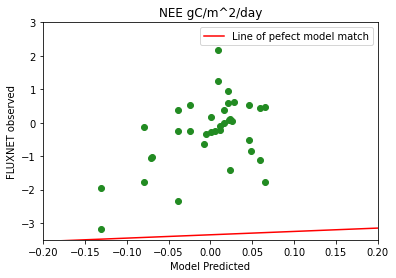

In [19]:
plt.scatter(rs_NEE[0], fluxnet_NEE['NEE_CUT_USTAR50'], color = 'forestgreen') 

# y = x trendline
x = np.linspace(-2, 2, 500)
y = x - 3.35
plt.plot(x, y, color='red', label = 'Line of pefect model match')
plt.xlim(-0.2,0.2)
plt.ylim(-3.5,3);

plt.title('NEE gC/m^2/day')
plt.ylabel('FLUXNET observed')
plt.xlabel('Model Predicted')
plt.legend();

In [20]:
print(rf_random.score(X_test, y_test))
print(rf_random.score(X_train, y_train))
print(rs_NEE[0].corr(fluxnet_NEE['NEE_CUT_USTAR50']))

0.7344820726997064
1.0
0.3265968162718299
